In [1]:
cd /tf/astromer

[Errno 2] No such file or directory: '/tf/astromer'
/home/users/cdonoso/astromer/astromer/presentation/notebooks


In [61]:
import h5py
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import BatchNormalization, Dense, LSTM, LayerNormalization, Normalization

In [234]:
def load_embeddings(source):
    file = open(source, 'rb')
    hf = h5py.File(file)
    att = hf['att'][()]
    x = hf['x'][()]
    t = hf['t'][()]
    lc = np.concatenate([t, x], 2)

    y = hf['y'][()]
    l = hf['id'][()]
    m = 1. - hf['m'][()]
    return att, y, l, m, lc

In [235]:
x_0, y_0, l_0, m_0, lc_0 = load_embeddings('../../embeddings/alcock/train.h5')

In [236]:
x_1, y_1, l_1, m_1, lc_1 = load_embeddings('../../embeddings/alcock/val.h5')

In [237]:
n_classes = len(np.unique(y_0))
n_classes

6

In [295]:
x_train_1 = np.sum(x_0*m_0, 1)/tf.reduce_sum(m_0, 1)
x_train_2 = np.sum(x_1*m_1, 1)/tf.reduce_sum(m_1, 1)


In [241]:
x_train = np.concatenate([x_train_1, x_train_2])
y_train = np.concatenate([y_0, y_1])


m_train = np.concatenate([m_0, m_1])
x_train.shape

(4000, 256)

In [242]:
y_train_oneot = tf.one_hot(y_train, n_classes)
y_train_oneot.shape

TensorShape([4000, 6])

In [243]:
# inputs = tf.keras.Input(shape=(200, 256), name='input')
# mask = tf.keras.Input(shape=(200, ), dtype=tf.bool, name='mask')

# x_mean = tf.expand_dims(tf.reduce_mean(inputs, 1), 1)
# x_std = tf.expand_dims(tf.math.reduce_std(inputs, 1), 1)
# x = (inputs - x_mean)/x_std
# x = LSTM(256, dropout=0.2, return_sequences=True)(x, mask=mask)
# x = LayerNormalization()(x)
# x = LSTM(256, dropout=0.2)(x, mask=mask)
# x = LayerNormalization()(x)
# x = Dense(n_classes)(x)

# model = tf.keras.Model(inputs=[inputs, mask], outputs=x)

In [215]:
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(200, 256)))
# model.add(LSTM(256, dropout=0.5, return_sequences=True))
# model.add(LayerNormalization())
# model.add(LSTM(256, dropout=0.5))
# model.add(LayerNormalization())
# model.add(Dense(n_classes))

In [374]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(256)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(LayerNormalization())
model.add(Dense(n_classes))

In [375]:
inputs = tf.keras.Input(shape=(256))
x_mean = tf.expand_dims(tf.reduce_mean(inputs, 1), 1)
x_std = tf.expand_dims(tf.math.reduce_std(inputs, 1), 1)
x = (inputs - x_mean)/x_std
x = Dense(1024)(x)
x = LayerNormalization()(x)
x = Dense(512)(x)
x = LayerNormalization()(x)
x = Dense(256)(x)
x = LayerNormalization()(x)
x = Dense(n_classes)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

In [376]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf.math.reduce_mean_12 (TFOpLam (None,)              0           input_17[0][0]                   
__________________________________________________________________________________________________
tf.expand_dims_38 (TFOpLambda)  (None, 1)            0           tf.math.reduce_mean_12[0][0]     
__________________________________________________________________________________________________
tf.math.reduce_std_12 (TFOpLamb (None,)              0           input_17[0][0]                   
___________________________________________________________________________________________

In [377]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [378]:
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=CategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [379]:
estop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [380]:
%%time
hist = model.fit(x_train, y_train_oneot, 
                 epochs=10000,
                 batch_size=2048,
                 callbacks=[estop],
                 validation_split=0.2)

Epoch 1/10000
2/2 [==============================] - 1s 188ms/step - loss: 4.1474 - accuracy: 0.1434 - val_loss: 6.8668 - val_accuracy: 0.1475
Epoch 2/10000
2/2 [==============================] - 0s 32ms/step - loss: 6.5047 - accuracy: 0.1709 - val_loss: 6.2921 - val_accuracy: 0.1762
Epoch 3/10000
2/2 [==============================] - 0s 33ms/step - loss: 5.6693 - accuracy: 0.1853 - val_loss: 4.6616 - val_accuracy: 0.1838
Epoch 4/10000
2/2 [==============================] - 0s 32ms/step - loss: 4.0846 - accuracy: 0.1903 - val_loss: 3.2854 - val_accuracy: 0.1575
Epoch 5/10000
2/2 [==============================] - 0s 31ms/step - loss: 2.9167 - accuracy: 0.1791 - val_loss: 2.5758 - val_accuracy: 0.1863
Epoch 6/10000
2/2 [==============================] - 0s 34ms/step - loss: 2.3305 - accuracy: 0.1912 - val_loss: 1.9733 - val_accuracy: 0.2175
Epoch 7/10000
2/2 [==============================] - 0s 31ms/step - loss: 2.0544 - accuracy: 0.1972 - val_loss: 2.1233 - val_accuracy: 0.2138
Epoch

2/2 [==============================] - 0s 31ms/step - loss: 1.6594 - accuracy: 0.2531 - val_loss: 1.6525 - val_accuracy: 0.2962
Epoch 59/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.6582 - accuracy: 0.2600 - val_loss: 1.6532 - val_accuracy: 0.2013
Epoch 60/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.6577 - accuracy: 0.2053 - val_loss: 1.6534 - val_accuracy: 0.2037
Epoch 61/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.6565 - accuracy: 0.2109 - val_loss: 1.6524 - val_accuracy: 0.2087
Epoch 62/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.6559 - accuracy: 0.2612 - val_loss: 1.6501 - val_accuracy: 0.2925
Epoch 63/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.6554 - accuracy: 0.2912 - val_loss: 1.6478 - val_accuracy: 0.3050
Epoch 64/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.6544 - accuracy: 0.2853 - val_loss: 1.6477 - val_accuracy: 0.2125
Epoch 65/10000

2/2 [==============================] - 0s 31ms/step - loss: 1.6081 - accuracy: 0.3450 - val_loss: 1.6019 - val_accuracy: 0.3175
Epoch 116/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.6063 - accuracy: 0.3159 - val_loss: 1.5962 - val_accuracy: 0.2738
Epoch 117/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.6037 - accuracy: 0.2700 - val_loss: 1.5971 - val_accuracy: 0.3300
Epoch 118/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.6027 - accuracy: 0.3331 - val_loss: 1.5949 - val_accuracy: 0.3537
Epoch 119/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.6003 - accuracy: 0.3594 - val_loss: 1.5948 - val_accuracy: 0.3363
Epoch 120/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.5994 - accuracy: 0.3434 - val_loss: 1.5878 - val_accuracy: 0.3713
Epoch 121/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.5924 - accuracy: 0.3516 - val_loss: 1.5808 - val_accuracy: 0.2925
Epoch 12

2/2 [==============================] - 0s 30ms/step - loss: 1.6341 - accuracy: 0.2419 - val_loss: 1.6326 - val_accuracy: 0.2900
Epoch 173/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.6459 - accuracy: 0.2666 - val_loss: 1.6306 - val_accuracy: 0.3887
Epoch 174/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.6434 - accuracy: 0.3328 - val_loss: 1.6177 - val_accuracy: 0.2150
Epoch 175/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.6314 - accuracy: 0.2294 - val_loss: 1.6102 - val_accuracy: 0.3175
Epoch 176/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.6269 - accuracy: 0.3125 - val_loss: 1.6110 - val_accuracy: 0.3187
Epoch 177/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.6275 - accuracy: 0.3106 - val_loss: 1.6061 - val_accuracy: 0.3875
Epoch 178/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.6234 - accuracy: 0.3597 - val_loss: 1.5996 - val_accuracy: 0.2525
Epoch 17

2/2 [==============================] - 0s 31ms/step - loss: 1.6168 - accuracy: 0.3259 - val_loss: 1.6429 - val_accuracy: 0.3350
Epoch 230/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.6682 - accuracy: 0.3150 - val_loss: 1.5684 - val_accuracy: 0.2663
Epoch 231/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.5973 - accuracy: 0.2991 - val_loss: 1.5641 - val_accuracy: 0.3438
Epoch 232/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.6068 - accuracy: 0.3031 - val_loss: 1.5663 - val_accuracy: 0.3025
Epoch 233/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.5998 - accuracy: 0.3172 - val_loss: 1.5602 - val_accuracy: 0.3475
Epoch 234/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.5850 - accuracy: 0.3003 - val_loss: 1.5724 - val_accuracy: 0.4137
Epoch 235/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.5892 - accuracy: 0.3809 - val_loss: 1.5588 - val_accuracy: 0.3613
Epoch 23

2/2 [==============================] - 0s 30ms/step - loss: 1.4155 - accuracy: 0.4187 - val_loss: 1.3717 - val_accuracy: 0.4688
Epoch 287/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.3949 - accuracy: 0.4509 - val_loss: 1.3571 - val_accuracy: 0.5113
Epoch 288/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.3813 - accuracy: 0.4641 - val_loss: 1.3480 - val_accuracy: 0.4625
Epoch 289/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.3631 - accuracy: 0.4772 - val_loss: 1.3354 - val_accuracy: 0.4675
Epoch 290/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.3433 - accuracy: 0.4497 - val_loss: 1.3281 - val_accuracy: 0.4700
Epoch 291/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.3322 - accuracy: 0.4597 - val_loss: 1.3094 - val_accuracy: 0.4938
Epoch 292/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.3067 - accuracy: 0.4812 - val_loss: 1.3063 - val_accuracy: 0.4938
Epoch 29

2/2 [==============================] - 0s 32ms/step - loss: 1.5711 - accuracy: 0.4166 - val_loss: 1.4555 - val_accuracy: 0.4675
Epoch 344/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.6400 - accuracy: 0.4091 - val_loss: 1.4698 - val_accuracy: 0.4175
Epoch 345/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.5385 - accuracy: 0.4044 - val_loss: 1.3608 - val_accuracy: 0.4125
Epoch 346/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.3709 - accuracy: 0.3997 - val_loss: 1.4325 - val_accuracy: 0.3975
Epoch 347/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.4207 - accuracy: 0.3919 - val_loss: 1.3528 - val_accuracy: 0.3738
Epoch 348/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.3892 - accuracy: 0.3841 - val_loss: 1.3672 - val_accuracy: 0.4187
Epoch 349/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.3946 - accuracy: 0.3769 - val_loss: 1.3600 - val_accuracy: 0.4750
Epoch 35

2/2 [==============================] - 0s 33ms/step - loss: 1.5304 - accuracy: 0.4544 - val_loss: 1.5145 - val_accuracy: 0.4112
Epoch 401/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.5258 - accuracy: 0.4281 - val_loss: 1.5093 - val_accuracy: 0.4300
Epoch 402/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.5206 - accuracy: 0.4347 - val_loss: 1.5008 - val_accuracy: 0.4462
Epoch 403/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.5133 - accuracy: 0.4563 - val_loss: 1.4942 - val_accuracy: 0.4787
Epoch 404/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.5071 - accuracy: 0.4916 - val_loss: 1.4903 - val_accuracy: 0.4875
Epoch 405/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.5008 - accuracy: 0.4909 - val_loss: 1.4862 - val_accuracy: 0.4837
Epoch 406/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.4930 - accuracy: 0.4947 - val_loss: 1.4782 - val_accuracy: 0.4625
Epoch 40

2/2 [==============================] - 0s 30ms/step - loss: 1.1764 - accuracy: 0.5266 - val_loss: 1.1814 - val_accuracy: 0.5238
Epoch 458/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1881 - accuracy: 0.5272 - val_loss: 1.1870 - val_accuracy: 0.5150
Epoch 459/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.1787 - accuracy: 0.5091 - val_loss: 1.1724 - val_accuracy: 0.5288
Epoch 460/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1855 - accuracy: 0.5319 - val_loss: 1.1759 - val_accuracy: 0.5325
Epoch 461/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1724 - accuracy: 0.5159 - val_loss: 1.1576 - val_accuracy: 0.5362
Epoch 462/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1668 - accuracy: 0.5412 - val_loss: 1.1781 - val_accuracy: 0.5125
Epoch 463/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1716 - accuracy: 0.5172 - val_loss: 1.2283 - val_accuracy: 0.4925
Epoch 46

2/2 [==============================] - 0s 32ms/step - loss: 1.2189 - accuracy: 0.4797 - val_loss: 1.1932 - val_accuracy: 0.4888
Epoch 515/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.1954 - accuracy: 0.4972 - val_loss: 1.1824 - val_accuracy: 0.4925
Epoch 516/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.2242 - accuracy: 0.4647 - val_loss: 1.1173 - val_accuracy: 0.5512
Epoch 517/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.1788 - accuracy: 0.5116 - val_loss: 1.1417 - val_accuracy: 0.5125
Epoch 518/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1645 - accuracy: 0.5197 - val_loss: 1.1798 - val_accuracy: 0.4750
Epoch 519/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1781 - accuracy: 0.4988 - val_loss: 1.1531 - val_accuracy: 0.5063
Epoch 520/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1584 - accuracy: 0.5219 - val_loss: 1.1374 - val_accuracy: 0.5100
Epoch 52

2/2 [==============================] - 0s 30ms/step - loss: 1.1615 - accuracy: 0.5253 - val_loss: 1.1452 - val_accuracy: 0.5387
Epoch 572/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.1533 - accuracy: 0.5450 - val_loss: 1.1400 - val_accuracy: 0.5475
Epoch 573/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.1392 - accuracy: 0.5306 - val_loss: 1.1273 - val_accuracy: 0.5337
Epoch 574/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1326 - accuracy: 0.5362 - val_loss: 1.1287 - val_accuracy: 0.5450
Epoch 575/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1265 - accuracy: 0.5462 - val_loss: 1.1231 - val_accuracy: 0.5350
Epoch 576/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1246 - accuracy: 0.5288 - val_loss: 1.1327 - val_accuracy: 0.5412
Epoch 577/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1218 - accuracy: 0.5437 - val_loss: 1.1142 - val_accuracy: 0.5425
Epoch 57

2/2 [==============================] - 0s 31ms/step - loss: 1.0799 - accuracy: 0.5531 - val_loss: 1.0955 - val_accuracy: 0.5312
Epoch 629/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1019 - accuracy: 0.5462 - val_loss: 1.0840 - val_accuracy: 0.5713
Epoch 630/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0808 - accuracy: 0.5569 - val_loss: 1.0700 - val_accuracy: 0.5575
Epoch 631/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0795 - accuracy: 0.5531 - val_loss: 1.0777 - val_accuracy: 0.5663
Epoch 632/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0798 - accuracy: 0.5500 - val_loss: 1.0694 - val_accuracy: 0.5612
Epoch 633/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0705 - accuracy: 0.5584 - val_loss: 1.0642 - val_accuracy: 0.5487
Epoch 634/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0737 - accuracy: 0.5541 - val_loss: 1.0946 - val_accuracy: 0.5337
Epoch 63

2/2 [==============================] - 0s 32ms/step - loss: 1.0739 - accuracy: 0.5584 - val_loss: 1.0793 - val_accuracy: 0.5312
Epoch 686/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0709 - accuracy: 0.5578 - val_loss: 1.0742 - val_accuracy: 0.5512
Epoch 687/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0657 - accuracy: 0.5519 - val_loss: 1.0710 - val_accuracy: 0.5400
Epoch 688/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0894 - accuracy: 0.5459 - val_loss: 1.1278 - val_accuracy: 0.5337
Epoch 689/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.1355 - accuracy: 0.5316 - val_loss: 1.1193 - val_accuracy: 0.5238
Epoch 690/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.0975 - accuracy: 0.5366 - val_loss: 1.1625 - val_accuracy: 0.5038
Epoch 691/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1446 - accuracy: 0.5159 - val_loss: 1.0877 - val_accuracy: 0.5537
Epoch 69

2/2 [==============================] - 0s 34ms/step - loss: 1.0534 - accuracy: 0.5647 - val_loss: 1.0928 - val_accuracy: 0.5362
Epoch 743/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0728 - accuracy: 0.5566 - val_loss: 1.0702 - val_accuracy: 0.5638
Epoch 744/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0619 - accuracy: 0.5638 - val_loss: 1.1058 - val_accuracy: 0.5150
Epoch 745/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0955 - accuracy: 0.5475 - val_loss: 1.0538 - val_accuracy: 0.5550
Epoch 746/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.0586 - accuracy: 0.5634 - val_loss: 1.1099 - val_accuracy: 0.5375
Epoch 747/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0874 - accuracy: 0.5266 - val_loss: 1.0924 - val_accuracy: 0.5425
Epoch 748/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0824 - accuracy: 0.5481 - val_loss: 1.0856 - val_accuracy: 0.5612
Epoch 74

2/2 [==============================] - 0s 33ms/step - loss: 1.0384 - accuracy: 0.5581 - val_loss: 1.1899 - val_accuracy: 0.4913
Epoch 800/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.1929 - accuracy: 0.4884 - val_loss: 1.0929 - val_accuracy: 0.5437
Epoch 801/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1506 - accuracy: 0.5197 - val_loss: 1.0697 - val_accuracy: 0.5550
Epoch 802/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1130 - accuracy: 0.5213 - val_loss: 1.0925 - val_accuracy: 0.5562
Epoch 803/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.0971 - accuracy: 0.5462 - val_loss: 1.0987 - val_accuracy: 0.5387
Epoch 804/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0981 - accuracy: 0.5359 - val_loss: 1.1455 - val_accuracy: 0.5188
Epoch 805/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1051 - accuracy: 0.5256 - val_loss: 1.1139 - val_accuracy: 0.5163
Epoch 80

2/2 [==============================] - 0s 31ms/step - loss: 1.0403 - accuracy: 0.5725 - val_loss: 1.0620 - val_accuracy: 0.5425
Epoch 857/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0428 - accuracy: 0.5772 - val_loss: 1.0870 - val_accuracy: 0.5387
Epoch 858/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0682 - accuracy: 0.5584 - val_loss: 1.0612 - val_accuracy: 0.5525
Epoch 859/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0452 - accuracy: 0.5675 - val_loss: 1.0850 - val_accuracy: 0.5175
Epoch 860/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0571 - accuracy: 0.5484 - val_loss: 1.0474 - val_accuracy: 0.5512
Epoch 861/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0333 - accuracy: 0.5797 - val_loss: 1.0570 - val_accuracy: 0.5537
Epoch 862/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0349 - accuracy: 0.5688 - val_loss: 1.0439 - val_accuracy: 0.5688
Epoch 86

2/2 [==============================] - 0s 30ms/step - loss: 1.0483 - accuracy: 0.5669 - val_loss: 1.0459 - val_accuracy: 0.5500
Epoch 914/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0367 - accuracy: 0.5697 - val_loss: 1.0598 - val_accuracy: 0.5437
Epoch 915/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0398 - accuracy: 0.5638 - val_loss: 1.0465 - val_accuracy: 0.5462
Epoch 916/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0467 - accuracy: 0.5628 - val_loss: 1.1241 - val_accuracy: 0.5450
Epoch 917/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1130 - accuracy: 0.5350 - val_loss: 1.1140 - val_accuracy: 0.5475
Epoch 918/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0877 - accuracy: 0.5381 - val_loss: 1.0841 - val_accuracy: 0.5300
Epoch 919/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0969 - accuracy: 0.5416 - val_loss: 1.0964 - val_accuracy: 0.5350
Epoch 92

2/2 [==============================] - 0s 31ms/step - loss: 1.0287 - accuracy: 0.5716 - val_loss: 1.0258 - val_accuracy: 0.5550
Epoch 971/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0153 - accuracy: 0.5838 - val_loss: 1.0605 - val_accuracy: 0.5412
Epoch 972/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0424 - accuracy: 0.5638 - val_loss: 1.0473 - val_accuracy: 0.5475
Epoch 973/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0474 - accuracy: 0.5609 - val_loss: 1.0240 - val_accuracy: 0.5462
Epoch 974/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0231 - accuracy: 0.5775 - val_loss: 1.0814 - val_accuracy: 0.5437
Epoch 975/10000
2/2 [==============================] - 0s 28ms/step - loss: 1.0586 - accuracy: 0.5487 - val_loss: 1.0904 - val_accuracy: 0.5362
Epoch 976/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0832 - accuracy: 0.5456 - val_loss: 1.0490 - val_accuracy: 0.5437
Epoch 97

Epoch 1027/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0173 - accuracy: 0.5869 - val_loss: 1.0565 - val_accuracy: 0.5387
Epoch 1028/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0791 - accuracy: 0.5372 - val_loss: 1.1129 - val_accuracy: 0.5337
Epoch 1029/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1006 - accuracy: 0.5322 - val_loss: 1.1098 - val_accuracy: 0.5125
Epoch 1030/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1186 - accuracy: 0.5216 - val_loss: 1.0502 - val_accuracy: 0.5325
Epoch 1031/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0389 - accuracy: 0.5747 - val_loss: 1.0617 - val_accuracy: 0.5425
Epoch 1032/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0714 - accuracy: 0.5416 - val_loss: 1.0909 - val_accuracy: 0.5138
Epoch 1033/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0791 - accuracy: 0.5341 - val_loss: 1.1247 - val_ac

2/2 [==============================] - 0s 30ms/step - loss: 1.0265 - accuracy: 0.5644 - val_loss: 1.0163 - val_accuracy: 0.5575
Epoch 1084/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0074 - accuracy: 0.5853 - val_loss: 1.0357 - val_accuracy: 0.5638
Epoch 1085/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0226 - accuracy: 0.5719 - val_loss: 1.0347 - val_accuracy: 0.5500
Epoch 1086/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0686 - accuracy: 0.5609 - val_loss: 1.1890 - val_accuracy: 0.4675
Epoch 1087/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1466 - accuracy: 0.5128 - val_loss: 1.0460 - val_accuracy: 0.5487
Epoch 1088/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0723 - accuracy: 0.5350 - val_loss: 1.0757 - val_accuracy: 0.5175
Epoch 1089/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0398 - accuracy: 0.5525 - val_loss: 1.0825 - val_accuracy: 0.5025
Ep

2/2 [==============================] - 0s 30ms/step - loss: 1.2434 - accuracy: 0.4641 - val_loss: 1.1843 - val_accuracy: 0.5113
Epoch 1140/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.1720 - accuracy: 0.4975 - val_loss: 1.1483 - val_accuracy: 0.4825
Epoch 1141/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.1539 - accuracy: 0.4944 - val_loss: 1.1101 - val_accuracy: 0.5312
Epoch 1142/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1146 - accuracy: 0.5322 - val_loss: 1.1287 - val_accuracy: 0.5125
Epoch 1143/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.1420 - accuracy: 0.5172 - val_loss: 1.0730 - val_accuracy: 0.5550
Epoch 1144/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0698 - accuracy: 0.5634 - val_loss: 1.1543 - val_accuracy: 0.5088
Epoch 1145/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.1066 - accuracy: 0.5347 - val_loss: 1.0968 - val_accuracy: 0.5250
Ep

2/2 [==============================] - 0s 30ms/step - loss: 0.9929 - accuracy: 0.6019 - val_loss: 1.0363 - val_accuracy: 0.5312
Epoch 1196/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0053 - accuracy: 0.5797 - val_loss: 1.0268 - val_accuracy: 0.5525
Epoch 1197/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0064 - accuracy: 0.5778 - val_loss: 1.0119 - val_accuracy: 0.5525
Epoch 1198/10000
2/2 [==============================] - 0s 33ms/step - loss: 0.9940 - accuracy: 0.5875 - val_loss: 1.0196 - val_accuracy: 0.5575
Epoch 1199/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0095 - accuracy: 0.5803 - val_loss: 1.0399 - val_accuracy: 0.5425
Epoch 1200/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0209 - accuracy: 0.5750 - val_loss: 1.0631 - val_accuracy: 0.5387
Epoch 1201/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0476 - accuracy: 0.5531 - val_loss: 1.0294 - val_accuracy: 0.5562
Ep

2/2 [==============================] - 0s 32ms/step - loss: 1.0529 - accuracy: 0.5375 - val_loss: 1.0995 - val_accuracy: 0.4837
Epoch 1252/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.0623 - accuracy: 0.5253 - val_loss: 1.0461 - val_accuracy: 0.5612
Epoch 1253/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0301 - accuracy: 0.5650 - val_loss: 1.0767 - val_accuracy: 0.5175
Epoch 1254/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0402 - accuracy: 0.5444 - val_loss: 1.0590 - val_accuracy: 0.5362
Epoch 1255/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0496 - accuracy: 0.5647 - val_loss: 1.0593 - val_accuracy: 0.5450
Epoch 1256/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0238 - accuracy: 0.5794 - val_loss: 1.0272 - val_accuracy: 0.5362
Epoch 1257/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0216 - accuracy: 0.5734 - val_loss: 1.0338 - val_accuracy: 0.5437
Ep

2/2 [==============================] - 0s 32ms/step - loss: 1.0173 - accuracy: 0.5775 - val_loss: 1.0789 - val_accuracy: 0.5350
Epoch 1308/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0331 - accuracy: 0.5656 - val_loss: 1.0645 - val_accuracy: 0.5462
Epoch 1309/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0257 - accuracy: 0.5675 - val_loss: 1.0465 - val_accuracy: 0.5475
Epoch 1310/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0139 - accuracy: 0.5803 - val_loss: 1.0730 - val_accuracy: 0.5425
Epoch 1311/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0598 - accuracy: 0.5547 - val_loss: 1.0199 - val_accuracy: 0.5537
Epoch 1312/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0166 - accuracy: 0.5844 - val_loss: 0.9976 - val_accuracy: 0.5725
Epoch 1313/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.0104 - accuracy: 0.5869 - val_loss: 0.9972 - val_accuracy: 0.5725
Ep

2/2 [==============================] - 0s 32ms/step - loss: 1.0094 - accuracy: 0.5784 - val_loss: 1.0182 - val_accuracy: 0.5512
Epoch 1364/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0049 - accuracy: 0.5797 - val_loss: 1.0006 - val_accuracy: 0.5612
Epoch 1365/10000
2/2 [==============================] - 0s 31ms/step - loss: 0.9891 - accuracy: 0.5759 - val_loss: 1.0079 - val_accuracy: 0.5437
Epoch 1366/10000
2/2 [==============================] - 0s 30ms/step - loss: 0.9930 - accuracy: 0.5909 - val_loss: 1.0081 - val_accuracy: 0.5437
Epoch 1367/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0102 - accuracy: 0.5734 - val_loss: 1.1712 - val_accuracy: 0.5263
Epoch 1368/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.1064 - accuracy: 0.5487 - val_loss: 1.1261 - val_accuracy: 0.5188
Epoch 1369/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0944 - accuracy: 0.5366 - val_loss: 1.0511 - val_accuracy: 0.5238
Ep

2/2 [==============================] - 0s 29ms/step - loss: 0.9949 - accuracy: 0.5828 - val_loss: 1.0289 - val_accuracy: 0.5450
Epoch 1420/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0031 - accuracy: 0.5803 - val_loss: 1.0070 - val_accuracy: 0.5600
Epoch 1421/10000
2/2 [==============================] - 0s 31ms/step - loss: 0.9898 - accuracy: 0.5953 - val_loss: 1.0497 - val_accuracy: 0.5437
Epoch 1422/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0077 - accuracy: 0.5828 - val_loss: 1.0354 - val_accuracy: 0.5437
Epoch 1423/10000
2/2 [==============================] - 0s 30ms/step - loss: 1.0314 - accuracy: 0.5794 - val_loss: 1.0636 - val_accuracy: 0.5425
Epoch 1424/10000
2/2 [==============================] - 0s 29ms/step - loss: 1.0349 - accuracy: 0.5528 - val_loss: 1.0062 - val_accuracy: 0.5638
Epoch 1425/10000
2/2 [==============================] - 0s 30ms/step - loss: 0.9923 - accuracy: 0.5844 - val_loss: 1.0247 - val_accuracy: 0.5437
Ep

2/2 [==============================] - 0s 31ms/step - loss: 1.0133 - accuracy: 0.5728 - val_loss: 1.0383 - val_accuracy: 0.5487
Epoch 1476/10000
2/2 [==============================] - 0s 33ms/step - loss: 1.0113 - accuracy: 0.5847 - val_loss: 1.0446 - val_accuracy: 0.5562
Epoch 1477/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0037 - accuracy: 0.5816 - val_loss: 1.0338 - val_accuracy: 0.5462
Epoch 1478/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0380 - accuracy: 0.5794 - val_loss: 1.0323 - val_accuracy: 0.5587
Epoch 1479/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0133 - accuracy: 0.5809 - val_loss: 1.0969 - val_accuracy: 0.5312
Epoch 1480/10000
2/2 [==============================] - 0s 31ms/step - loss: 1.0923 - accuracy: 0.5500 - val_loss: 1.0393 - val_accuracy: 0.5525
Epoch 1481/10000
2/2 [==============================] - 0s 32ms/step - loss: 1.0554 - accuracy: 0.5609 - val_loss: 1.2093 - val_accuracy: 0.5013
Ep

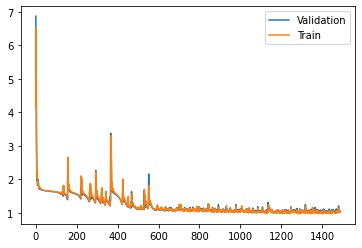

In [381]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_loss'], label='Validation')
plt.plot(hist.history['loss'], label='Train')
plt.legend()

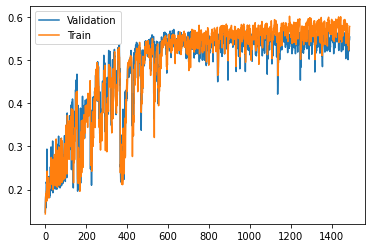

In [382]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.plot(hist.history['accuracy'], label='Train')
plt.legend()

In [383]:
model.save('../../experiments/alcock/mlp')

INFO:tensorflow:Assets written to: ../../experiments/alcock/mlp/assets


INFO:tensorflow:Assets written to: ../../experiments/alcock/mlp/assets


## Testing

In [384]:
import tensorflow as tf
import h5py
import numpy as np

from sklearn.metrics import precision_recall_fscore_support

In [385]:
model = tf.keras.models.load_model('../../experiments/alcock/mlp/')

In [386]:
x_test, y_test, l, m_test, x = load_embeddings('../../embeddings/alcock/test.h5')

In [387]:
x_test = np.sum(x_test*m_test, 1)/tf.reduce_sum(m_test, 1)

In [388]:
y_pred = model.predict(x_test)
y_pred_labs = tf.argmax(y_pred, 1)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_labs, average='macro')

In [389]:
'{:.2f}'.format(f1), '{:.2f}'.format(prec), '{:.2f}'.format(rec)

('0.60', '0.60', '0.60')